In [9]:
import os
# from osgeo import gdal
import numpy as np
from skimage.io import imread, imsave
from pathlib import Path
import random
import matplotlib.pyplot as plt
from osgeo import gdal

In [3]:
fileName = "../data/processed/RGB.Copy.png"
img = imread(fileName)

In [5]:
save_path = "../data/processed/RGB"
new_name = 99
ext = '.png'
print(f"{save_path}/{new_name:04d}{ext}")

../data/processed/RGB/0099.png


In [17]:
def read_rasterArray(image_path):
    dataset = gdal.Open(image_path, gdal.GA_ReadOnly)
    image = dataset.ReadAsArray()  # get the rasterArray
    # convert 2D raster to [1, H, W] format
    if len(image.shape) == 2:
        image = image[np.newaxis, :, :]

    print(type(image), image.shape, image_path)
    width = dataset.RasterXSize
    height = dataset.RasterYSize

    print(f"Image Size (H, W):{height, width}")
    proj = dataset.GetProjection()
    geotrans = dataset.GetGeoTransform()
    return image

In [18]:
tif_image_path = "../data/processed/MUL.tif"
save_tif_image_path = "../data/processed/MUL"
crop_size = 100
repetition_rate = 0
overwrite = True

In [19]:
img = read_rasterArray(tif_image_path)

<class 'numpy.ndarray'> (8, 251, 270) ../data/processed/MUL.tif
Image Size (H, W):(251, 270)


In [22]:
img.shape, img.min(), img.max(), img.dtype

((8, 251, 270), 12, 1372, dtype('uint16'))

In [23]:
save_tif_tile_image_path = "../data/processed/MUL/0001.tif"
img_tile = read_rasterArray(save_tif_tile_image_path)
img_tile.shape, img_tile.min(), img_tile.max(), img_tile.dtype


<class 'numpy.ndarray'> (8, 100, 100) ../data/processed/MUL/0001.tif
Image Size (H, W):(100, 100)


((8, 100, 100), 20, 1286, dtype('uint16'))

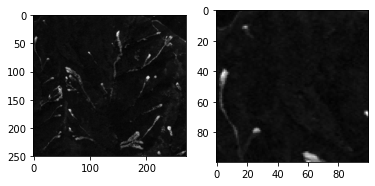

In [29]:

plt.subplot(1, 2, 1)
plt.imshow(np.squeeze(img[1,:,:]), cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(np.squeeze(img_tile[1,:,:]), cmap='gray')
plt.show()

In [42]:
%load_ext autoreload
%autoreload 2
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

from skimage.io import imread, imsave
import os 
import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [43]:
class DatasetSegmentation(torch.utils.data.Dataset):
    def __init__(self, image_path, label_path):
#         super(DataLoaderSegmentation, self).__init__()
        self.imgfolder = image_path
        self.maskfolder = label_path
        self.imgs = list(sorted(os.listdir(image_path)))
        self.masks = list(sorted(os.listdir(label_path)))

    def __getitem__(self, idx):
        img_path = os.path.join(self.imgfolder, self.imgs[idx])
        mask_path = os.path.join(self.maskfolder, self.masks[idx])
        data = imread(img_path)
        data = np.moveaxis(data, -1, 0)
        label = imread(mask_path)
        label = label/255
        return torch.from_numpy(data).float(), torch.from_numpy(label).long()

    def __len__(self):
        return len(self.imgs)

In [44]:
AerialDataset = DatasetSegmentation("../data/processed/RGB", "../data/processed/GT")

In [45]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(AerialDataset, batch_size=16, shuffle=False)
 

In [46]:
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

Feature batch shape: torch.Size([16, 3, 256, 256])
Labels batch shape: torch.Size([16, 256, 256])


Feature batch shape: ((3, 256, 256), 212.0, 29.0)
Labels batch shape: ((256, 256), 1, 0)


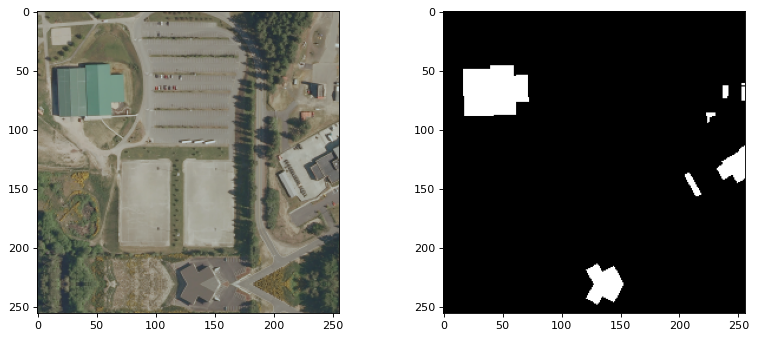

In [52]:
import random
idx = random.randint(0, 15)

img = train_features[idx].squeeze().numpy()
label = train_labels[idx].squeeze().numpy()

print(f"Feature batch shape: {img.shape, img.max(), img.min()}")
print(f"Labels batch shape: {label.shape, label.max(), label.min()}")


img = np.moveaxis(img, 0, -1)

from matplotlib.pyplot import figure

figure(figsize=(12, 5), dpi=80)
plt.subplot(1,2,1)
plt.imshow(img.astype(np.uint8) )
plt.subplot(1,2,2)

plt.imshow(label.astype(np.uint8), cmap="gray")
plt.show()

In [48]:
import torchvision
grid_img = torchvision.utils.make_grid(train_features/255, nrow=4)
grid_label = torchvision.utils.make_grid(train_labels.unsqueeze_(1), nrow=4)

In [49]:
grid_img.shape, grid_label.shape

(torch.Size([3, 1034, 1034]), torch.Size([3, 1034, 1034]))

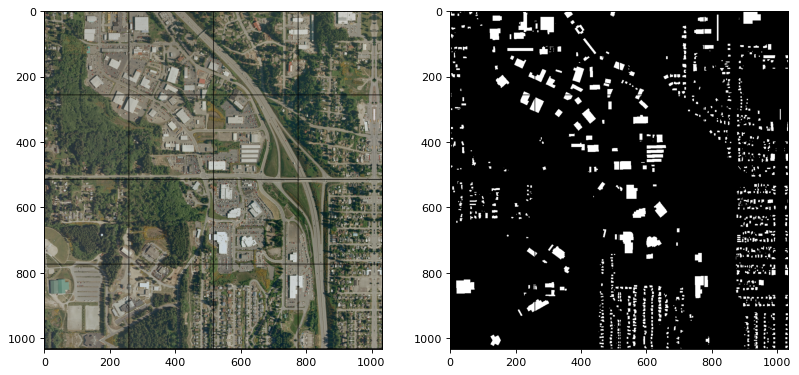

In [50]:
figure(figsize=(12, 18), dpi=80)
plt.subplot(1,2,1)
plt.imshow(grid_img.permute(1, 2, 0))
plt.subplot(1,2,2)
plt.imshow(grid_label[0,:,:], cmap='gray')